# ISM Reconstruction - noisy (2PE data)

In ISM several slightly shifted images are recroded with a detector array and at the reconstruction stage they need to be fused together to generate a higher-SNR (and resolution) output image. 

In [1]:
%matplotlib inline

import os
from scipy.io import loadmat
import numpy as np
from supertomo.data.io import carma
from supertomo.ui.plots import image as implots

# Image
data_dir = "/Users/sami/Documents/Work/Data/2018_05_2PE_ISM"
filename = "20170810_224328_729_45um_deep.mat"
full_path = os.path.join(data_dir, filename)

## Import Data

The image data is contained in a special Carma file format. Images are organized according to 1. the detector they were recorded with and 2. the laser gate number during which they were recorded. There's a special data structure *ArrayDetectorData* for holding such image collections in memory inside SuperTomo. Alternatively a HDF5 based *ImageData* structure can be used, in case the images are very large.

The Carma file 20170810_224328_729_45um_deep.mat contains images from 1 laser gates and 25 detector channels.


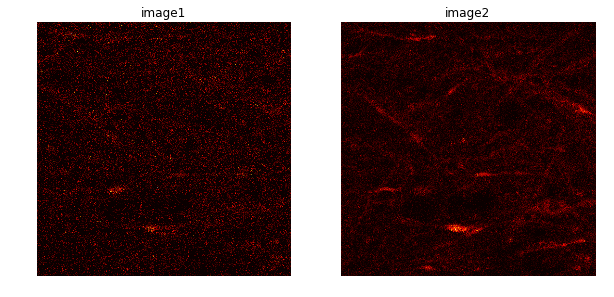

In [16]:
data = carma.read_carma_mat(full_path)

print "The Carma file {} contains images from {} laser gates and {} detector channels.".format(
    filename, data.ngates, data.ndetectors)
implots.display_2d_images(data[0,24], data[0,12])

## Evaluate data quality

The template image shown holds information of the effective system PSF and also it can be used to evaluate how well the detector was aligned during data acquisition.

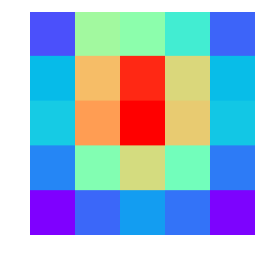

In [3]:
from supertomo.processing.ism import helpers as ismhelpers

template = ismhelpers.make_template_image(data)

implots.display_2d_image(template[0])

## Registration

In order to perform the reassignment the images have to be registered (aligned into a single coordinate grid). For this I use a iterative image registration algorithm that I originally developed for a CLEM application. Let's first try this out with a single image pair. The image number 12 is the central pixel, whereas 8 is one of the corner pixels in the 3x3 central area.

Setting up registration job
Starting registration
Final metric value: -0.146090951712
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 27 iterations. Gradient magnitude (3.86564e-05) is less than gradient magnitude tolerance (0.0001).


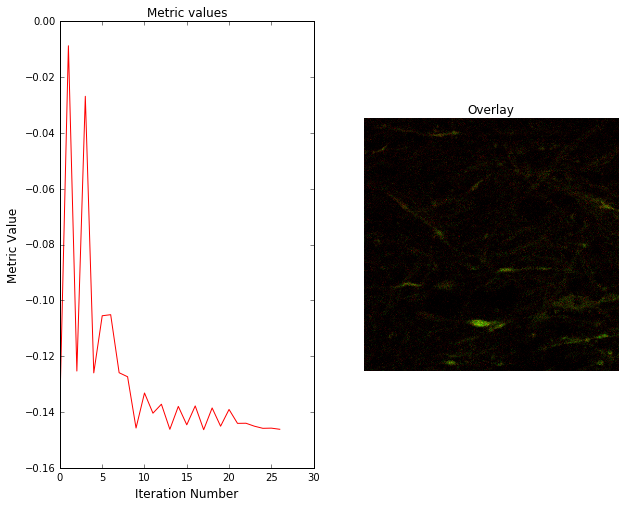

In [17]:
import supertomo.ui.supertomo_options as options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(data[0, 12])
moving_image = itk.convert_to_itk_image(data[0, 7])


args = ("{} --sampling-percentage=1 --reg-relax-factor=.8 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only " 
        "--reg-enable-observers".format(full_path)).split()

options = options.get_ism_script_options(args)

transform = registration.itk_registration_rigid_2d(fixed_image, moving_image, options)

In [5]:
print transform

itk::simple::Transform
 TranslationTransform (0x7fb1ab268520)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 4001171
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [0.0995336, -0.188312]



Seems to work fine, so lets do the same for all the images in the dataset. There's a specific ISM alignment function *find_image_shifts(ArrayDataContainer, options)* in SuperTomo that can be used for this puropose. The command line parameters (args) here are tuned more for accuracy rather than speed. 

In [6]:
import supertomo.ui.supertomo_options as options
import supertomo.processing.ism.reconstruction as ismrec

args = ("{} --sampling-percentage=1 --reg-relax-factor=.8 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only ".format(full_path)).split()

options = options.get_ism_script_options(args)

x,y,tranforms = ismrec.find_image_shifts(data, options)


Setting up registration job
Starting registration
Final metric value: -0.0333565273032
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 22 iterations. Gradient magnitude (5.57357e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.0656687652259
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 19 iterations. Gradient magnitude (6.22523e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.0980275369225
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 22 iterations. Gradient magnitude (7.06215e-05) is less than gradient magnitude tolerance (0.0001).
Setting up registration job
Starting registration
Final metric value: -0.0754944465928
Optimizer's stopping c

# Reassign (fuse)

The simplest reassignment is just a sum of the shifted images. There' a *shift_and_sum()* function in the library for doing this. *image1* is the central detector image and *image2* the reassignment result.

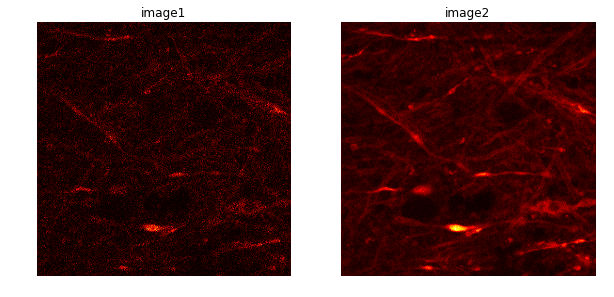

In [7]:
result = ismrec.shift_and_sum(data, tranforms)

implots.display_2d_images(data[0,12], result.astype(np.uint32))

## Realtime reassignment

It would of course be nice to be able to see the reassignment result in realtime during imaging. In order to do that the reassignment has to be run pixel-by-pixel and there's no possibility/time to perform the image alignment. Therefore one has to obtain the shifts beforehad. In theory they could be estimated from the detector specifications (pixel spacing), but in practice, many factors affect the actual shift between the images. Therefore one needs to find the shifts by calibration measurements. Let's see what that looks like.

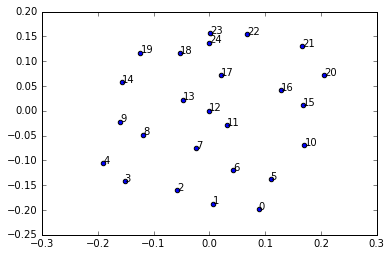

In [8]:
import supertomo.ui.plots.scatter as scatter


#shifts.plot(x='x', y='y', kind='scatter')

scatter.xy_scatter_plot_with_labels(x,y, range(len(x)))

Let's first discretize the shifts by converting from physical units to pixel space. That way one can find out how many pixels each pixel from a given image needs to be shifted in the result image.

In [19]:
import pandas
shifts = pandas.DataFrame({'x': x, 'y': y})

spacing = data[0,0].spacing

shifts['x_px'] = shifts['x']/spacing[0]
shifts['y_px'] = shifts['y']/spacing[1]

shifts.x_px = shifts.x_px.round()
shifts.y_px = shifts.y_px.round()
print spacing

print shifts

[0.050050050050050053, 0.050050050050050053]
           x         y  x_px  y_px
0   0.088424 -0.198978   2.0  -4.0
1   0.006000 -0.187220   0.0  -4.0
2  -0.058032 -0.160207  -1.0  -3.0
3  -0.151635 -0.141525  -3.0  -3.0
4  -0.190359 -0.105800  -4.0  -2.0
5   0.109907 -0.137443   2.0  -3.0
6   0.042485 -0.119815   1.0  -2.0
7  -0.023262 -0.075824  -0.0  -2.0
8  -0.118430 -0.048264  -2.0  -1.0
9  -0.159363 -0.021989  -3.0  -0.0
10  0.170401 -0.069607   3.0  -1.0
11  0.032108 -0.028969   1.0  -1.0
12  0.000000  0.000000   0.0   0.0
13 -0.046983  0.022155  -1.0   0.0
14 -0.156437  0.057782  -3.0   1.0
15  0.167585  0.010924   3.0   0.0
16  0.128053  0.041581   3.0   1.0
17  0.020132  0.072180   0.0   1.0
18 -0.052598  0.115975  -1.0   2.0
19 -0.123595  0.116922  -2.0   2.0
20  0.205218  0.071775   4.0   1.0
21  0.165847  0.130508   3.0   3.0
22  0.067779  0.153912   1.0   3.0
23  0.002060  0.156370   0.0   3.0
24 -0.000963  0.136945  -0.0   3.0


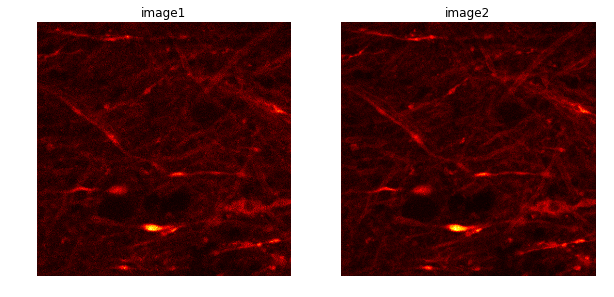

In [12]:
from supertomo.data.containers.image import Image
dims = data[0,0].shape

result_sum = Image(np.zeros(dims, dtype=np.float64), spacing)

for image in data:
    result_sum += image
    
implots.display_2d_images(result_sum.astype(np.int32), result.astype(np.uint32))

In [13]:
from supertomo.data.io import write as imwrite
import SimpleITK as sitk
import supertomo.processing.itk as itkutils


def write_image(path, image):
    """
    A writer for ITK supported image formats.

    :param path:    A full path to the image.
    :param image:   An image as :type image: numpy.ndarray.
    :param spacing: Pixel size ZXY, as a :type spacing: list.
    """
    assert isinstance(image, Image)

    image = itkutils.convert_to_itk_image(image)
    sitk.WriteImage(image, path)


In [18]:
ism_name = "ism_result.mha"
sum_name = "sum_result.mha"

write_image(os.path.join(data_dir, ism_name), Image(result.astype(np.uint8), result.spacing))
write_image(os.path.join(data_dir, sum_name), Image(result_sum.astype(np.uint8), result.spacing))

